## Tutorial: Perceptrón (clasificador lineal) con scikit-learn

Este cuaderno es una guía práctica y directa para entender el Perceptrón, el modelo lineal más sencillo y base de muchas redes neuronales. Vamos a entrenarlo paso a paso con scikit-learn para resolver una tarea muy conocida: la compuerta lógica AND.

Al finalizar, podrás:
- Entender qué hace el Perceptrón y cuándo usarlo.
- Entrenarlo, evaluarlo y visualizar su frontera de decisión.
- Reconocer por qué no funciona en problemas no lineales (como XOR) y qué alternativas considerar.

## 1 Fundamentos

El Perceptrón es un algoritmo de clasificación binaria propuesto en 1957 por Frank Rosenblatt. En esencia, modela una neurona artificial que:

- Recibe varias entradas (características).
- Las pondera con pesos, suma el resultado y añade un sesgo (bias).
- Aplica una función escalón para decidir entre dos clases.

Qué problema resuelve: separar dos clases mediante una recta (en 2D) o un hiperplano (en dimensiones mayores).

Durante el entrenamiento, ajusta pesos y sesgo cuando se equivoca, desplazando la frontera de decisión para mejorar las predicciones.

Limitación clave: solo funciona bien si las clases son linealmente separables (existe una frontera recta/hiperplano que las separa). Por ejemplo, el problema XOR no puede resolverse con un Perceptrón simple.

## 2 Modelo matemático

El Perceptrón realiza dos pasos: una suma ponderada y una activación escalón.

1) Suma ponderada (entrada neta)

Dadas características $x_1, x_2, \dots, x_m$, pesos $w_1, w_2, \dots, w_m$ y sesgo $b$:

$$z = \mathbf{w} \cdot \mathbf{x} + b = \sum_{i=1}^{m} w_i x_i + b$$

2) Activación (escalón)

La salida predicha es:

$$\hat{y} = \begin{cases}
1 & \text{si } z \ge 0 \\
0 & \text{si } z < 0
\end{cases}$$

Aprendizaje (regla de actualización)

Si se equivoca, actualiza así:

$$w_i \leftarrow w_i + \eta\,(y - \hat{y})\,x_i,\qquad b \leftarrow b + \eta\,(y - \hat{y})$$

Donde $\eta$ es la tasa de aprendizaje (paso).

Intuición geométrica:
- Los pesos $\mathbf{w}$ determinan la orientación de la frontera (recta/hiperplano).
- El sesgo $b$ desplaza la frontera hacia arriba/abajo (o a través de las dimensiones) sin cambiar su orientación.
- El umbral clásico $\theta$ es equivalente a usar un sesgo $b = -\theta$.

## 3 Herramientas que usaremos

- Numpy: para crear y manipular arrays (datos X e y).
- Scikit-learn: para el modelo `Perceptron` y utilidades como métricas.
  - `Perceptron(eta0, max_iter, random_state)`: entrena y ajusta pesos/sesgo.
  - `accuracy_score`: mide qué porcentaje de aciertos tenemos.
- Matplotlib: para visualizar datos y la frontera de decisión.

Importamos lo necesario a continuación.

In [11]:
%pip install numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## 4 Pipeline de Machine Learning

Vamos a seguir estos pasos:

1) Preparar los datos (AND) y verlos.
2) Elegir el modelo (Perceptrón) y por qué tiene sentido aquí.
3) Entrenar el modelo.
4) Predecir y evaluar.
5) Visualizar la frontera y estudiar cómo aprende por épocas.

### 4.1 Datos (Feature Engineering)

Para AND usamos dos entradas binarias $X_1$ y $X_2$, y una salida $Y$.

Tabla de verdad:

| $X_1$ | $X_2$ | $Y$ |
| :---: | :---: | :--: |
| 0 | 0 | 0 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Crearemos `X` (características) e `y` (etiquetas) con Numpy. Luego, los graficamos para ver que se pueden separar con una línea.

In [13]:
# 1. Definir las características (Features)
# Cada fila es una muestra [X1, X2]
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# 2. Definir las etiquetas (Target)
y = np.array([0, 0, 0, 1])

print("--- Datos de la Compuerta AND ---")
print("Características (X):\n", X)
print("\nEtiquetas (y):\n", y)

--- Datos de la Compuerta AND ---
Características (X):
 [[0 0]
 [0 1]
 [1 0]
 [1 1]]

Etiquetas (y):
 [0 0 0 1]


Podemos graficarlos para confirmar que son linealmente separables (una recta puede separar las clases).

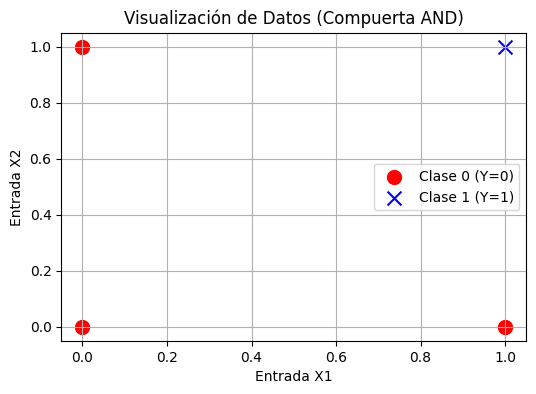

Observamos que los datos son linealmente separables.
Una línea recta (ej. y = -x + 1.5) puede separar los puntos azules de los rojos.


In [14]:
# Visualización de los datos
plt.figure(figsize=(6, 4))

# Dibujar puntos para la Clase 0 (Rojo)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', marker='o', s=100, label='Clase 0 (Y=0)')

# Dibujar puntos para la Clase 1 (Azul)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', marker='x', s=100, label='Clase 1 (Y=1)')

plt.title('Visualización de Datos (Compuerta AND)')
plt.xlabel('Entrada X1')
plt.ylabel('Entrada X2')
plt.legend()
plt.grid(True)
plt.show()

print("Observamos que los datos son linealmente separables.")
print("Una línea recta (ej. y = -x + 1.5) puede separar los puntos azules de los rojos.")

### 4.2 ¿Por qué un Perceptrón aquí?

Porque AND es separable linealmente: existe una línea que separa perfectamente los puntos con Y=0 y Y=1. El Perceptrón aprende justamente una frontera lineal. Además, por el teorema de convergencia del Perceptrón, en problemas separables llega a una solución en un número finito de pasos.

### 4.3 Entrenamiento

Parámetros principales en scikit-learn:
- `eta0`: tasa de aprendizaje (tamaño del paso de actualización).
- `max_iter`: número máximo de pasadas por los datos (épocas).
- `random_state`: semilla para hacer reproducible el barajado interno.

Entrenamiento: `model.fit(X, y)` ajusta pesos y sesgo. En un problema separable como AND, el modelo converge (deja de cometer errores) antes de llegar a `max_iter`. Si no es separable, el algoritmo puede no converger.

In [15]:
# 1. Instanciar el modelo
# eta0 = Tasa de aprendizaje (qué tan rápido aprende)
# max_iter = Número máximo de épocas (pasadas por los datos)
# random_state = Semilla para que el experimento sea reproducible
perceptron_model = Perceptron(max_iter=1000, eta0=0.1, random_state=42)

# 2. Entrenar el modelo (Ajustar los pesos w y el sesgo b)
# El método .fit() ejecuta el algoritmo de aprendizaje
perceptron_model.fit(X, y)

print("¡Entrenamiento completado!")

# El modelo entrenado almacena los pesos (w) y el sesgo (b)
print(f"Pesos aprendidos (w): {perceptron_model.coef_}")
print(f"Sesgo aprendido (b): {perceptron_model.intercept_}")

¡Entrenamiento completado!
Pesos aprendidos (w): [[0.2 0.2]]
Sesgo aprendido (b): [-0.2]


In [16]:
# Demostración numérica: z = w·x + b y clase predicha
w = perceptron_model.coef_.ravel()
b = float(perceptron_model.intercept_[0])

print("Pesos (w):", w)
print("Sesgo (b):", b)
print("\nx      z = w·x + b   y_hat   y_real")
for xi, yi in zip(X, y):
    z = float(np.dot(w, xi) + b)
    y_hat = 1 if z >= 0 else 0
    print(f"{xi}    {z: .3f}         {y_hat}       {yi}")

Pesos (w): [0.2 0.2]
Sesgo (b): -0.20000000000000004

x      z = w·x + b   y_hat   y_real
[0 0]    -0.200         0       0
[0 1]    -0.000         0       0
[1 0]    -0.000         0       0
[1 1]     0.200         1       1


#### Nota: ¿Cómo decide el Perceptrón (paso a paso)?

- Calcula z = w·x + b, donde w son los pesos aprendidos, x es la entrada y b es el sesgo.
- Si z ≥ 0, predice 1; si z < 0, predice 0.
- Abajo mostramos z y la predicción para cada fila de AND usando los pesos del modelo entrenado.

Los pesos `w` (en `coef_`) y el sesgo `b` (en `intercept_`) definen la recta de decisión: $w_1 X_1 + w_2 X_2 + b = 0$. Todo lo que quede a un lado se predice como 1; al otro lado, 0.

### 4.4 Predicción

Con el modelo entrenado, usamos `.predict(...)` para ver qué clase asigna a cada entrada. Añadimos una función pequeña para imprimir las predicciones de forma clara.

In [17]:
def probar_perceptron(model, X_data, y_data):
    """
    Función para probar y reportar la clasificación de cada patrón de entrada.
    """
    print("\n--- Probando el Modelo (Patrón por Patrón) ---")
    
    correctas = 0
    for i in range(len(X_data)):
        # Tomamos un patrón (fila) de X
        patron_entrada = X_data[i]
        etiqueta_real = y_data[i]
        
        # El modelo espera una entrada 2D (batch_size, n_features)
        # Usamos .reshape(1, -1) para convertir [X1, X2] en [[X1, X2]]
        patron_formateado = patron_entrada.reshape(1, -1)
        
        # Realizar la predicción
        prediccion = model.predict(patron_formateado)
        
        # Comparar
        es_correcta = (prediccion[0] == etiqueta_real)
        if es_correcta:
            correctas += 1
            
        print(f"Entrada: {patron_entrada} -> Predicción: {prediccion[0]} (Real: {etiqueta_real}) | {'CORRECTO' if es_correcta else 'INCORRECTO'}")

    print(f"\nTotal correctas: {correctas} de {len(X_data)}")

# Probar el modelo con los mismos datos de entrenamiento
probar_perceptron(perceptron_model, X, y)


--- Probando el Modelo (Patrón por Patrón) ---
Entrada: [0 0] -> Predicción: 0 (Real: 0) | CORRECTO
Entrada: [0 1] -> Predicción: 0 (Real: 0) | CORRECTO
Entrada: [1 0] -> Predicción: 0 (Real: 0) | CORRECTO
Entrada: [1 1] -> Predicción: 1 (Real: 1) | CORRECTO

Total correctas: 4 de 4


### 4.5 Evaluación

La métrica más directa aquí es el Accuracy (porcentaje de aciertos):

$$\text{Accuracy} = \frac{\text{aciertos}}{\text{total de muestras}}$$

En AND (4 patrones), un 100% significa 4/4 aciertos. En casos reales, conviene además inspeccionar la matriz de confusión para ver en qué clase se equivoca el modelo.

In [18]:
# 1. Obtener predicciones para TODO el conjunto de datos a la vez
y_pred = perceptron_model.predict(X)

# 2. Calcular el Accuracy comparando las etiquetas reales (y) con las predichas (y_pred)
accuracy = accuracy_score(y, y_pred)

print("\n--- Evaluación del Modelo (Métrica Accuracy) ---")
print(f"Etiquetas Reales (y):    {y}")
print(f"Predicciones (y_pred): {y_pred}")
print(f"Accuracy (Precisión Global): {accuracy * 100:.2f}%")

print("\n--- Explicación de Resultados ---")
print(f"El modelo ha alcanzado un {accuracy * 100:.2f}% de Accuracy.")
print("Esto significa que clasificó correctamente el 100% de los patrones de entrada (4 de 4).")
print("Este resultado es el esperado, ya que el Perceptrón convergió exitosamente en este problema linealmente separable.")


--- Evaluación del Modelo (Métrica Accuracy) ---
Etiquetas Reales (y):    [0 0 0 1]
Predicciones (y_pred): [0 0 0 1]
Accuracy (Precisión Global): 100.00%

--- Explicación de Resultados ---
El modelo ha alcanzado un 100.00% de Accuracy.
Esto significa que clasificó correctamente el 100% de los patrones de entrada (4 de 4).
Este resultado es el esperado, ya que el Perceptrón convergió exitosamente en este problema linealmente separable.


### 4.6 Visualización del hiperplano de decisión

La figura colorea el plano según la clase predicha por el Perceptrón (zonas rojas y azules). La línea discontinua es la frontera $z=0$ (donde $w_1 X_1 + w_2 X_2 + b = 0$). Los puntos quedan a uno u otro lado según su clase.

C:\Users\brizi\AppData\Local\Temp\ipykernel_26460\1771542686.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_data[y_data == 1][:, 0], X_data[y_data == 1][:, 1],


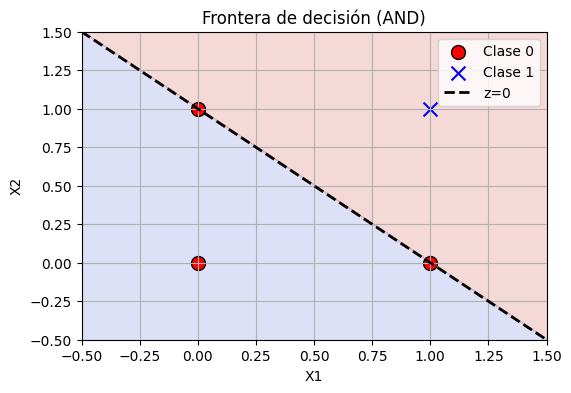

Ecuación aproximada: 0.200*X1 + 0.200*X2 + -0.200 = 0


In [19]:
# 1.4.6 Visualización del hiperplano de decisión (AND)

def plot_decision_boundary(model, X_data, y_data, title='Frontera de decisión (Perceptrón)'):
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.scatter(X_data[y_data == 0][:, 0], X_data[y_data == 0][:, 1],
                c='red', edgecolor='k', marker='o', s=100, label='Clase 0')
    plt.scatter(X_data[y_data == 1][:, 0], X_data[y_data == 1][:, 1],
                c='blue', edgecolor='k', marker='x', s=100, label='Clase 1')

    w = model.coef_.ravel()
    b = float(model.intercept_[0])
    if abs(w[1]) > 1e-8:
        xs = np.array([x_min, x_max])
        ys = -(w[0] / w[1]) * xs - b / w[1]
        plt.plot(xs, ys, 'k--', lw=2, label='z=0')

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Ecuación aproximada: {w[0]:.3f}*X1 + {w[1]:.3f}*X2 + {b:.3f} = 0")

# Graficar frontera para AND usando el modelo entrenado `perceptron_model`
plot_decision_boundary(perceptron_model, X, y, title='Frontera de decisión (AND)')

### 4.7 Dinámica del aprendizaje (épocas y errores)

En datos separables como AND, el número de errores cae a 0 en pocas épocas y el accuracy sube a 1. Con `partial_fit` podemos “ver” esa evolución paso a paso.

Pesos finales (tras epocas): [[0.1 0.2]]
Sesgo final (tras epocas): [-0.2]
 [[0.1 0.2]]
Sesgo final (tras epocas): [-0.2]


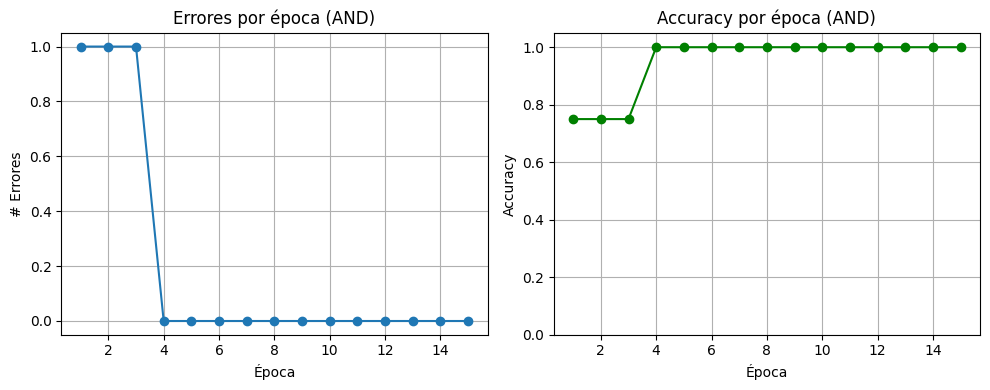

In [20]:
# 1.4.7 Dinámica del aprendizaje: épocas, errores y accuracy

from copy import deepcopy

def entrenar_por_epocas(X_data, y_data, epocas=15, eta=0.1, random_state=42, shuffle=True):
    """Entrena un Perceptrón con `partial_fit` por epocas, registrando métricas e historial de pesos/sesgo."""
    model = Perceptron(max_iter=1, tol=None, eta0=eta, random_state=random_state, shuffle=shuffle)
    classes = np.unique(y_data)
    pesos_hist, sesgo_hist, errores_hist, acc_hist = [], [], [], []
    
    for e in range(epocas):
        if e == 0:
            model.partial_fit(X_data, y_data, classes=classes)
        else:
            model.partial_fit(X_data, y_data)
        y_pred = model.predict(X_data)
        acc = accuracy_score(y_data, y_pred)
        errores = int((y_pred != y_data).sum())
        acc_hist.append(acc)
        errores_hist.append(errores)
        pesos_hist.append(deepcopy(model.coef_))
        sesgo_hist.append(deepcopy(model.intercept_))
    
    return model, np.array(pesos_hist).squeeze(), np.array(sesgo_hist).squeeze(), np.array(errores_hist), np.array(acc_hist)

modelo_ep, W_hist, b_hist, errores_hist, acc_hist = entrenar_por_epocas(X, y, epocas=15, eta=0.1)

print("Pesos finales (tras epocas):", modelo_ep.coef_)
print("Sesgo final (tras epocas):", modelo_ep.intercept_)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(errores_hist)+1), errores_hist, marker='o')
plt.title('Errores por época (AND)')
plt.xlabel('Época')
plt.ylabel('# Errores')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(acc_hist)+1), acc_hist, marker='o', color='green')
plt.title('Accuracy por época (AND)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

## 5 Limitaciones: el problema XOR

En XOR, las clases positivas y negativas se ubican en esquinas opuestas del plano (en diagonal). No existe una sola recta que las separe a la vez, por eso el Perceptrón no alcanza 100% de acierto. Alternativas: un modelo no lineal (p. ej., MLP) o añadir características no lineales y luego usar un modelo lineal.

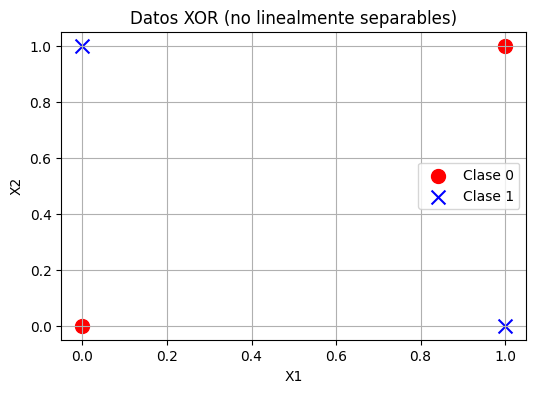

Accuracy en XOR: 50.00% (no se espera 100% por no ser separable)


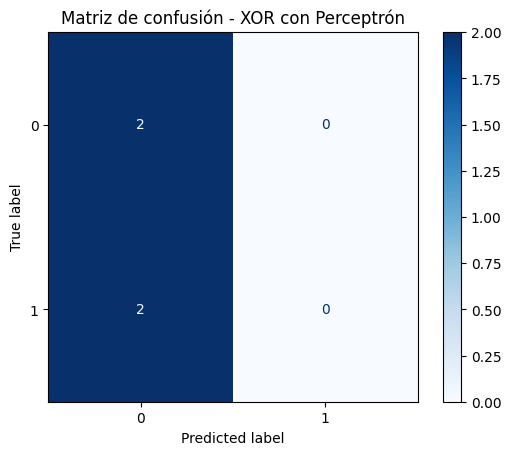

C:\Users\brizi\AppData\Local\Temp\ipykernel_26460\1771542686.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_data[y_data == 1][:, 0], X_data[y_data == 1][:, 1],


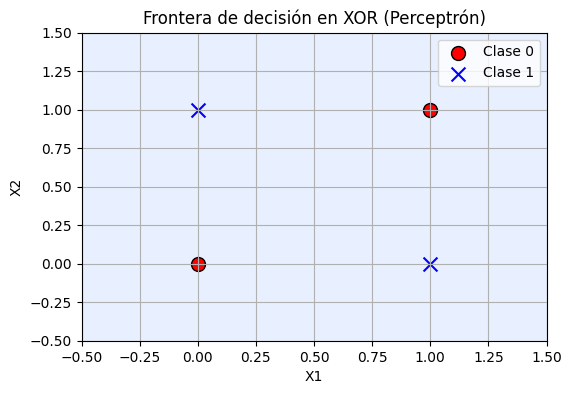

Ecuación aproximada: 0.000*X1 + 0.000*X2 + 0.000 = 0


In [21]:
# 1.5 Limitaciones: XOR (no linealmente separable)

# Dataset XOR: misma estructura 2D, pero esta vez no existe una línea que separe perfectamente las clases.
X_xor = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
y_xor = np.array([0, 1, 1, 0])  # XOR

plt.figure(figsize=(6, 4))
plt.scatter(X_xor[y_xor == 0][:, 0], X_xor[y_xor == 0][:, 1], color='red', marker='o', s=100, label='Clase 0')
plt.scatter(X_xor[y_xor == 1][:, 0], X_xor[y_xor == 1][:, 1], color='blue', marker='x', s=100, label='Clase 1')
plt.title('Datos XOR (no linealmente separables)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()

perceptron_xor = Perceptron(max_iter=2000, eta0=0.1, random_state=42)
perceptron_xor.fit(X_xor, y_xor)

y_xor_pred = perceptron_xor.predict(X_xor)
acc_xor = accuracy_score(y_xor, y_xor_pred)
print(f"Accuracy en XOR: {acc_xor*100:.2f}% (no se espera 100% por no ser separable)")

# Import local para asegurar disponibilidad aunque no se haya ejecutado la celda de imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_xor, y_xor_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión - XOR con Perceptrón')
plt.show()

# Si ya definimos la función de frontera (más abajo), podemos reutilizarla aquí:
try:
    plot_decision_boundary(perceptron_xor, X_xor, y_xor, title='Frontera de decisión en XOR (Perceptrón)')
except NameError:
    print('La función plot_decision_boundary se define en una celda posterior. Ejecútala y vuelve a correr esta celda para ver la frontera.')

## 6 Buenas prácticas

- Escala tus datos si las variables están en rangos muy distintos (p. ej., `StandardScaler`). Acelera y estabiliza el aprendizaje.
- Controla cuándo parar: `max_iter` limita épocas; `tol` activa parada temprana si no hay mejora.
- Reproducibilidad: fija `random_state` y decide si barajar (`shuffle`) ayuda o no.
- Si no hay separación lineal, el Perceptrón no converge. Alternativas: Regresión Logística, SVM lineal, o añadir features no lineales.
- Métricas: no te quedes solo con Accuracy si hay desbalance. Mira matriz de confusión, precisión y recobrado.
- Multiclase: scikit-learn usa One-vs-Rest automáticamente si `y` tiene más de dos clases.

## Referencias Bibliográficas

1.  **Rosenblatt, F. (1957).** *The Perceptron: A Probabilistic Model for Information Storage and Organization in the Brain.* Psychological Review, 64(6), 386–408. (El paper original).
2.  **Raschka, S., & Mirjalili, V. (2019).** *Python Machine Learning (3rd ed.).* Packt Publishing. (El Capítulo 2 introduce el Perceptrón).
3.  **Scikit-learn Documentation.** *1.1. Linear Models - Perceptron.* Recuperado de: [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)
4.  **Haykin, S. (2009).** *Neural Networks and Learning Machines (3rd ed.).* Pearson. (Un texto clásico sobre redes neuronales).
5.  **OpenAI. (2024).** *ChatGPT.* (Modelo de lenguaje grande). Consultado el 3/11/2025, de [https://chat.openai.com/](https://chat.openai.com/)